## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
import numpy as np
import torch,librosa

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from symbols import phone2id, tone2id, RPB2id
import scipy.io.wavfile as wavfile

In [9]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
def recover_wav(mel):
    n_fft = 2048
    win_length=hparams.win_length
    hop_length=hparams.hop_length
    mean, std = np.load( "../data/MeanStd_Tacotron_mel.npy")
    mel = mel_outputs.float().data.cpu().numpy()[0].transpose()
    temp1=np.tile(mean, (mel.shape[0],1))
    temp2=np.tile(std, (mel.shape[0],1))
    mel = mel * std + mean
    mel = np.exp(mel).transpose()
    filters = librosa.filters.mel(sr=hparams.sampling_rate, n_fft=n_fft, n_mels=hparams.n_mel_channels)
    inv_filters = np.linalg.pinv(filters)
    spec = np.dot(inv_filters, mel)

    def _griffin_lim(stftm_matrix, shape, max_iter=50):
        y = np.random.random(shape)
        for i in range(max_iter):
            stft_matrix = librosa.core.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
            stft_matrix = stftm_matrix * stft_matrix / np.abs(stft_matrix)
            y = librosa.core.istft(stft_matrix, win_length=win_length, hop_length=hop_length)
        return y

    shape = spec.shape[1] * hop_length -  hop_length + 1

    y = _griffin_lim(spec, shape)
    return y

#### Setup hparams

In [10]:
hparams = create_hparams()
hparams.sampling_rate = 16000

#### Load model from checkpoint

In [11]:
checkpoint_path = "../outdir/tacotron2_baseline_small/checkpoint_86800"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Prepare text input

In [19]:
test_text_path = "../data/text/00000001.lab"
sequence = np.loadtxt(test_text_path, 'str')
sequence = np.array([[phone2id[ph], tone2id[tn], RPB2id[RPB]] for ph, tn, RPB in sequence])[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

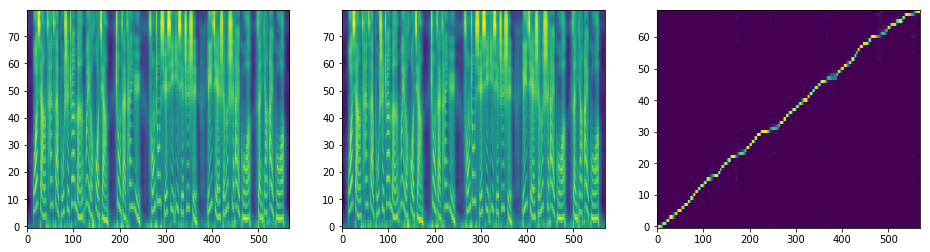

In [20]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Tacotron2 Synthesis

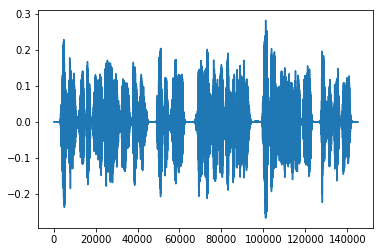

In [21]:
audio=recover_wav(mel_outputs)
plt.plot(audio)
ipd.Audio(audio, rate=hparams.sampling_rate)

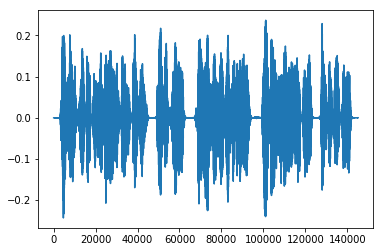

In [29]:
audio=recover_wav(mel_outputs_postnet)
plt.plot(audio)
ipd.Audio(audio, rate=hparams.sampling_rate)

In [30]:
wavfile.write('white.wav', 16000, audio)

In [ ]:
embedded_inputs_phoneme = model.embedding_phoneme(sequence[:,:,0]).transpose(1, 2)
embedded_inputs_tone = model.embedding_tone(sequence[:,:,1]).transpose(1, 2)
embedded_inputs = torch.cat((embedded_inputs_phoneme, embedded_inputs_tone), 1)
encoder_outputs = model.encoder.inference(embedded_inputs)
print((encoder_outputs.data.cpu().numpy()[0]))

In [27]:
audio.astype(np.int16)

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)